# 1. 导入必要的库

In [2]:
import pickle
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from scipy import signal

# 2. 定义要对比的模型列表

In [3]:
# --- 定义要对比的模型列表 ---
MODEL_LIST = [
    "dinov2_vits14", # Small
    "dinov2_vitb14", # Base
    "dinov2_vitl14"  # Large
]

# --- 图像预处理参数 (所有模型通用) ---
PATCH_SIZE = 14
IMAGE_SIZE = 770 # 14 * 55

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# 3. 图像预处理参数 (所有模型通用)

### image from url


In [8]:
image_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/pca/test_image.jpg"

def load_image_from_url(url):
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

def resize_transform(img, image_size=IMAGE_SIZE, patch_size=PATCH_SIZE):
    w, h = img.size
    new_h = int(image_size / patch_size)
    new_w = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(img, (new_h * patch_size, new_w * patch_size)))

print("Downloading and preparing image...")
image = load_image_from_url(image_uri)
image_resized = resize_transform(image)
image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD).unsqueeze(0).cuda()
print("Image preparation complete.")

Image preparation complete.


### image from local


In [5]:
local_image_path = "/home/meituan4090/project/catkin_ws/data/data/image_representation_negative_TS_l/36618734367651.png"

def load_image_from_path(path: str) -> Image:
    return Image.open(path).convert("RGB")

def resize_transform(img: Image, image_size: int = IMAGE_SIZE, patch_size: int = PATCH_SIZE) -> torch.Tensor:
    w, h = img.size
    new_h = int(image_size / patch_size)
    new_w = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(img, (new_h * patch_size, new_w * patch_size)))

print("正在加载并预处理本地图片...")
image = load_image_from_path(local_image_path)
image_resized = resize_transform(image)
image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD).unsqueeze(0).cuda()
print("图片处理完成。")

正在加载并预处理本地图片...
图片处理完成。


# 4. 循环处理每个模型并存储结果

In [9]:
results = {}

for model_name in MODEL_LIST:
    print(f"\n--- Processing model: {model_name} ---")
    # 1. 加载模型
    print("Loading model...")
    model = torch.hub.load('facebookresearch/dinov2', model_name)
    model.eval().cuda()
    # 2. 提取特征
    print("Extracting features...")
    with torch.no_grad():
        features_dict = model.forward_features(image_resized_norm)
        patch_features = features_dict['x_norm_patchtokens']
        x = patch_features.squeeze(0).detach().cpu()
    # 3. 拟合 PCA
    print("Fitting PCA...")
    pca = PCA(n_components=3, whiten=True)
    pca.fit(x)
    # 4. 计算 PCA 投影图像
    h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]
    projected_image = torch.from_numpy(pca.transform(x.numpy())).view(h_patches, w_patches, 3)
    projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0))
    # 5. 存储结果
    results[model_name] = projected_image
    print(f"Model {model_name} processed.")
    # 6. (重要) 释放 GPU 内存，为下一个模型做准备
    del model
    torch.cuda.empty_cache()


--- Processing model: dinov2_vits14 ---
Loading model...


Using cache found in /home/meituan4090/.cache/torch/hub/facebookresearch_dinov2_main


Extracting features...
Fitting PCA...
Model dinov2_vits14 processed.

--- Processing model: dinov2_vitb14 ---
Loading model...


Using cache found in /home/meituan4090/.cache/torch/hub/facebookresearch_dinov2_main


Extracting features...
Fitting PCA...
Model dinov2_vitb14 processed.

--- Processing model: dinov2_vitl14 ---
Loading model...


Using cache found in /home/meituan4090/.cache/torch/hub/facebookresearch_dinov2_main


Extracting features...
Fitting PCA...
Model dinov2_vitl14 processed.


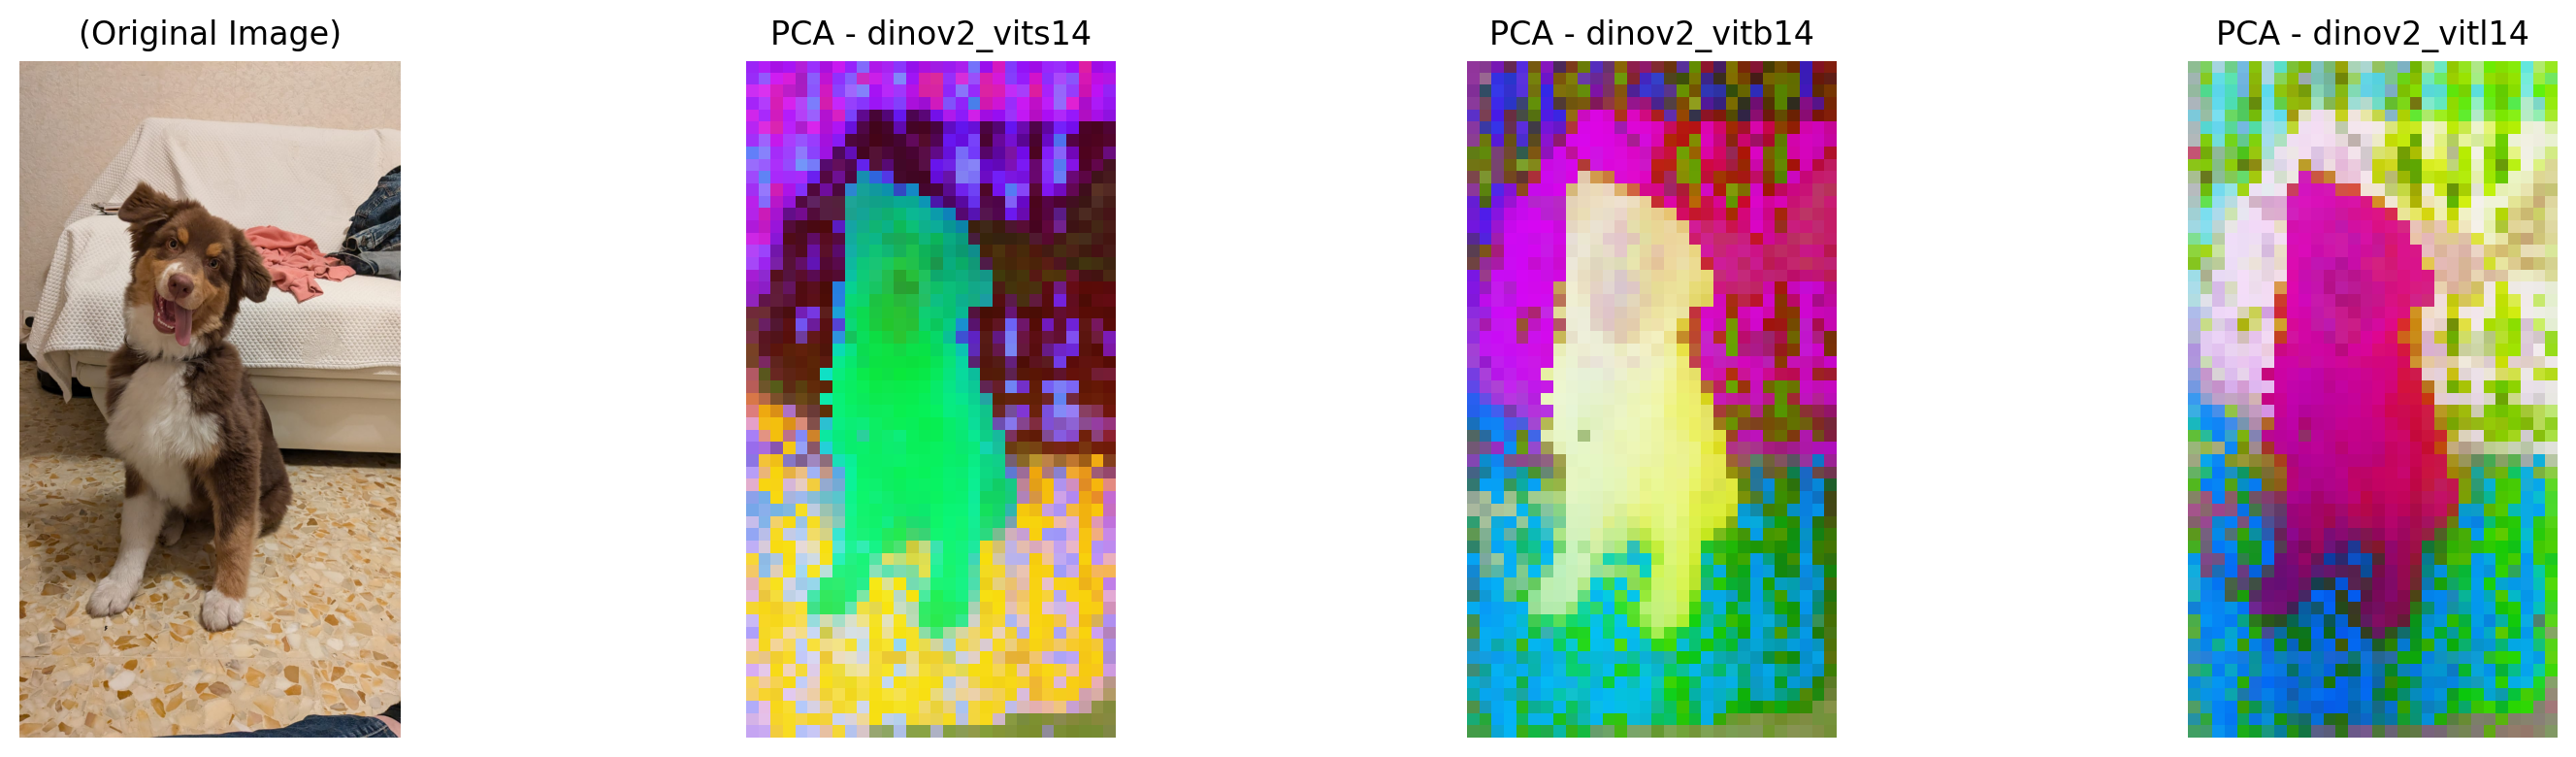

In [12]:
num_plots = len(MODEL_LIST) + 1

# --- 核心改动 ---
# 创建一个 1 行、num_plots 列的图窗。
# figsize 的宽度现在变大，高度变小，以适应横向布局。
fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4), dpi=200)

# 1. 在最左侧的子图 (axes[0]) 显示原图
axes[0].imshow(image)
axes[0].set_title("(Original Image)")
axes[0].axis('off')

# 2. 循环显示每个模型的 PCA 结果
for i, model_name in enumerate(MODEL_LIST):
    # 子图的索引从 1 开始
    ax = axes[i + 1]
    pca_image = results[model_name]

    im = ax.imshow(pca_image)
    # fig.colorbar(im, ax=ax)


    ax.set_title(f"PCA - {model_name}")
    ax.axis('off')

# 调整布局以防止标题重叠，然后显示图片
plt.tight_layout()
plt.savefig("../figs/pca_dinov2_comparison.png", bbox_inches='tight', dpi=200)
plt.show()


--- 正在处理模型: dinov2_vits14 ---


Using cache found in /home/meituan4090/.cache/torch/hub/facebookresearch_dinov2_main


为 dinov2_vits14 进行 K-Means 聚类并计算分数...
模型 dinov2_vits14 的轮廓系数为: 0.3323

--- 正在处理模型: dinov2_vitb14 ---


Using cache found in /home/meituan4090/.cache/torch/hub/facebookresearch_dinov2_main


为 dinov2_vitb14 进行 K-Means 聚类并计算分数...
模型 dinov2_vitb14 的轮廓系数为: 0.3117

--- 正在处理模型: dinov2_vitl14 ---


Using cache found in /home/meituan4090/.cache/torch/hub/facebookresearch_dinov2_main


为 dinov2_vitl14 进行 K-Means 聚类并计算分数...
模型 dinov2_vitl14 的轮廓系数为: 0.2652

--- 量化评估结果 (轮廓系数) ---
分数越高，代表前景和背景的特征分离得越好。
dinov2_vits14  : 0.3323
dinov2_vitb14  : 0.3117
dinov2_vitl14  : 0.2652


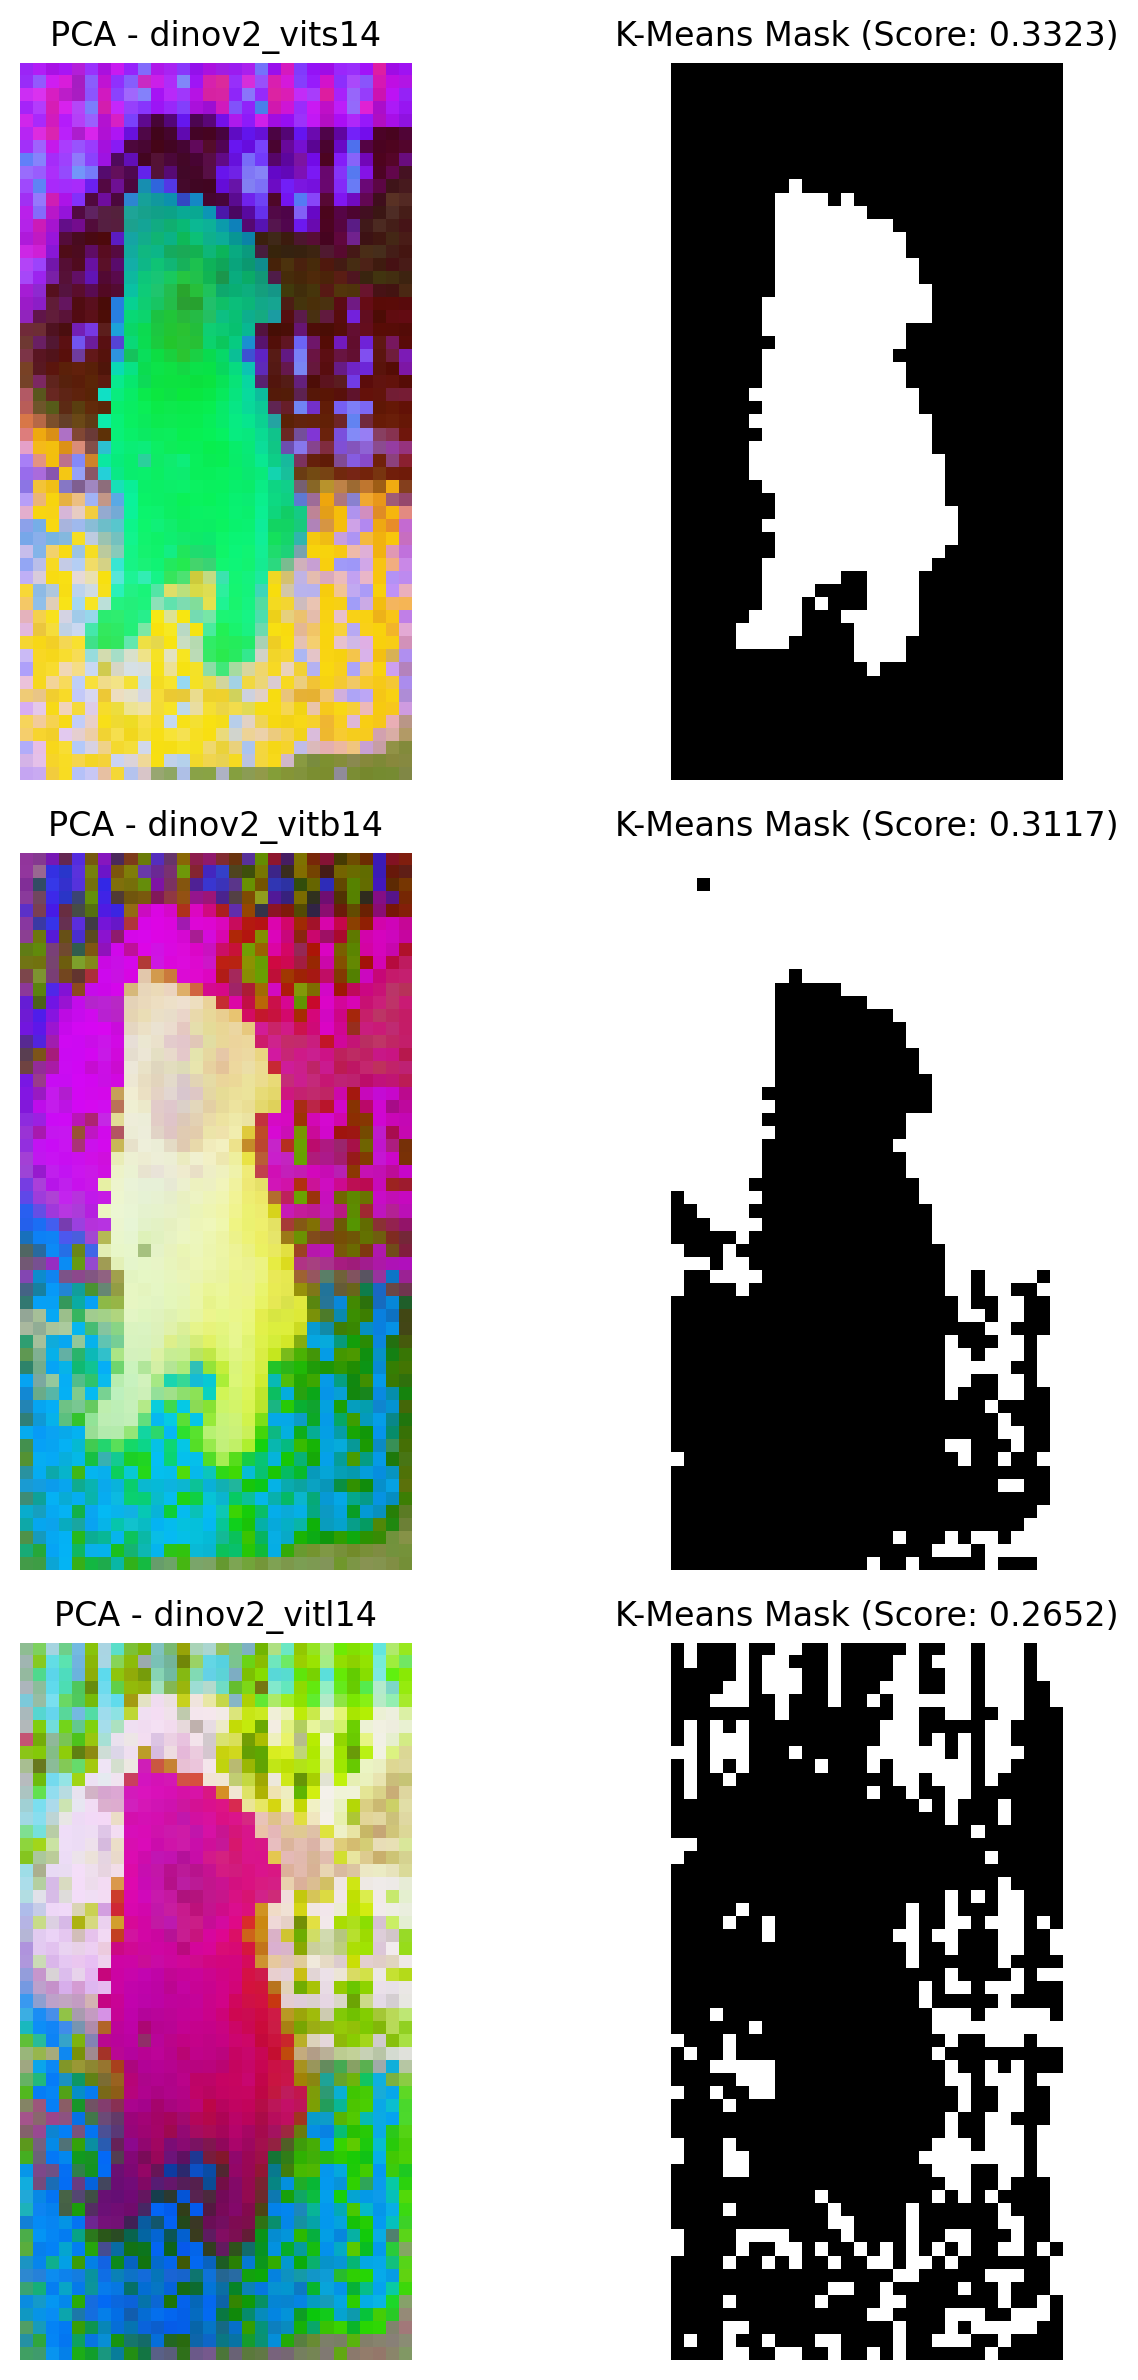

In [ ]:

# --- 关键修改：循环处理，计算并存储 PCA 结果和量化分数 ---
results = {} # 存储 PCA 图像
scores = {}  # 存储轮廓系数分数

for model_name in MODEL_LIST:
    print(f"\n--- 正在处理模型: {model_name} ---")
    
    # 1. 加载模型
    model = torch.hub.load('facebookresearch/dinov2', model_name); model.eval().cuda()
    
    # 2. 提取特征
    with torch.no_grad():
        features_dict = model.forward_features(image_resized_norm)
        x = features_dict['x_norm_patchtokens'].squeeze(0).detach().cpu()

    # 3. 拟合 PCA
    pca = PCA(n_components=3, whiten=True); pca.fit(x)
    
    # 4. 计算 PCA 投影特征
    h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]
    pca_features = pca.transform(x.numpy()) # 这是 (N, 3) 的特征
    
    # 5. --- 新增：使用 K-Means 聚类并计算轮廓系数 ---
    print(f"为 {model_name} 进行 K-Means 聚类并计算分数...")
    kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(pca_features)
    score = silhouette_score(pca_features, kmeans.labels_)
    scores[model_name] = score
    print(f"模型 {model_name} 的轮廓系数为: {score:.4f}")

    # 6. 生成可视化图像 (PCA 彩色图 和 K-Means 分割图)
    pca_image = torch.from_numpy(pca_features).view(h_patches, w_patches, 3)
    pca_image = torch.nn.functional.sigmoid(pca_image.mul(2.0))
    
    # 生成 K-Means 的黑白分割图
    kmeans_mask = kmeans.labels_.reshape(h_patches, w_patches)
    
    # 7. 存储结果
    results[model_name] = (pca_image, kmeans_mask)

    # 8. 释放内存
    del model; torch.cuda.empty_cache()

# In[5]:
# --- 打印最终的量化分数对比 ---
print("\n--- 量化评估结果 (轮廓系数) ---")
print("分数越高，代表前景和背景的特征分离得越好。")
for model_name, score in scores.items():
    print(f"{model_name:<15}: {score:.4f}")

# In[6]:
# --- 可视化对比 ---
# 每一行显示一个模型的结果：PCA图 + K-Means分割图
num_models = len(MODEL_LIST)
fig, axes = plt.subplots(num_models, 2, figsize=(8, 4 * num_models), dpi=200)

for i, model_name in enumerate(MODEL_LIST):
    pca_img, kmeans_mask = results[model_name]
    
    # 显示 PCA 彩色图
    axes[i, 0].imshow(pca_img)
    axes[i, 0].set_title(f"PCA - {model_name}")
    axes[i, 0].axis('off')
    
    # 显示 K-Means 分割图
    axes[i, 1].imshow(kmeans_mask, cmap='gray')
    axes[i, 1].set_title(f"K-Means Mask (Score: {scores[model_name]:.4f})")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()